In [2]:
%matplotlib inline

In [3]:
import os, datetime
import netCDF4 as nc
from netCDF4 import Dataset
import cftime
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import signal
import requests

In [4]:
def j2000_sec_to_datetime(unix_sec):
    dt0 = datetime.datetime(2000, 1, 1, 12)  # J2000 epoch reference
    unix_sec = np.array(unix_sec)  # Ensure input is a NumPy array
    dt_array = np.array([dt0 + datetime.timedelta(seconds=s) for s in unix_sec])
    return dt_array

def datetime_to_day(dt_array):
    # Ensure dt_array is a NumPy array of datetime objects
    dt_array = np.array(dt_array)
    t0 = dt_array[0]
    unix_seconds = np.array([(dt - t0).total_seconds() for dt in dt_array])
    return unix_seconds

def timeTicks(x, pos):
    d = datetime.timedelta(seconds=x)
    hours, remainder = divmod(int(d.total_seconds()), 3600)
    minutes, seconds = divmod(remainder, 60)
    return f"{hours}:{minutes:02}:{seconds:02}"

def format_time_axis(ax):
    locator = mdates.HourLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

In [6]:
#make sure to edit paths to match personal use
dataurl = 'https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes19/l2/data/magn-l2-hires'
subdir = '/2025/09/'
filename = "dn_magn-l2-hires_g19_d20250901_v1-0-3.nc"
#make sure to edit paths to match personal use
if not os.path.exists(filename):
    with open(filename, "wb") as f:
        url_path = dataurl+subdir+filename
        print(url_path)
        r = requests.get(url_path)
        print(r)
        f.write(r.content)

In [28]:
g16a = nc.Dataset(filename)

# Read magnetic field vector in VDH coordinates
VDH = g16a.variables['b_vdh']

# Convert time from J2000 epoch to datetime
TIME_UNITS = "seconds since 2000-01-01 12:00:00"
time = g16a.variables['time']
time = j2000_sec_to_datetime(time[:])
dt = datetime_to_day(time)
dts = cftime.num2pydate(g16a.variables['time'][:], g16a.variables['time'].units)

# Filter parameters
fs = 10  # Sampling frequency in Hz
lowcut = .01 # Lower bound of bandpass (Hz)
highcut = 3 # Upper bound of bandpass (Hz)
N = 1  # Filter order
NFFT = 1024  # FFT segment length
freqlim = 1.00 # Frequency limit for plotting
db_min, db_max = -20, 15  # Power level range for plotting
str_plt, end_plt = 0, 1066  # Indexes for plotting

# Apply bandpass filter to the V component (first column) of the magnetic field
befilteredV = butter_bandpass_filter(VDH[:, 0], lowcut, highcut, fs, order=5)

In [29]:
dt

array([0.00000e+00, 1.00000e-01, 2.00000e-01, ..., 8.63997e+04,
       8.63998e+04, 8.63999e+04])

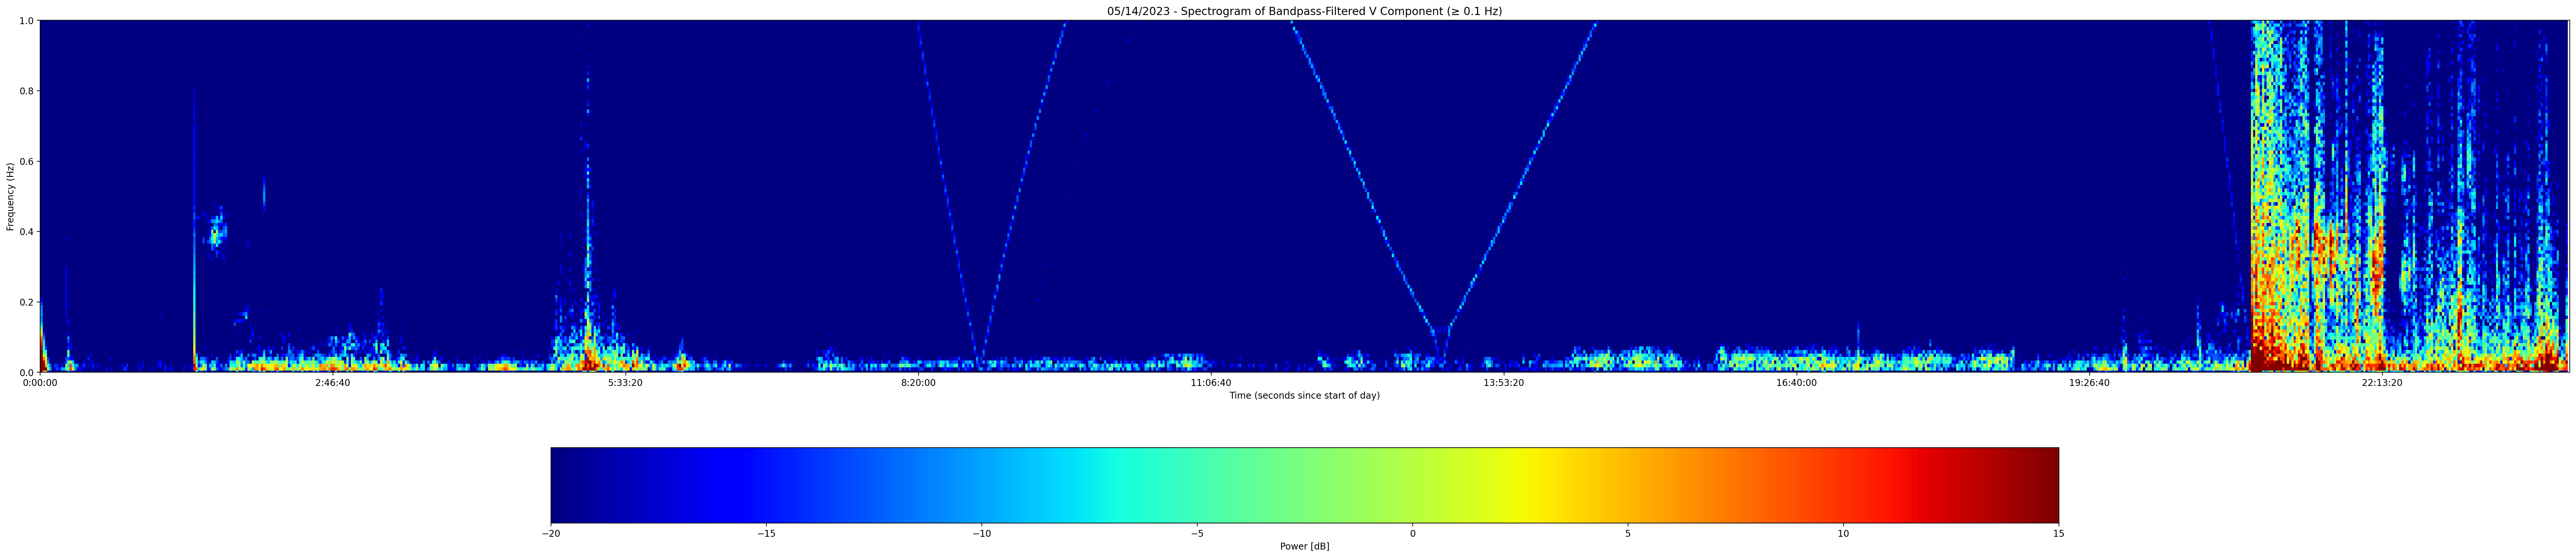

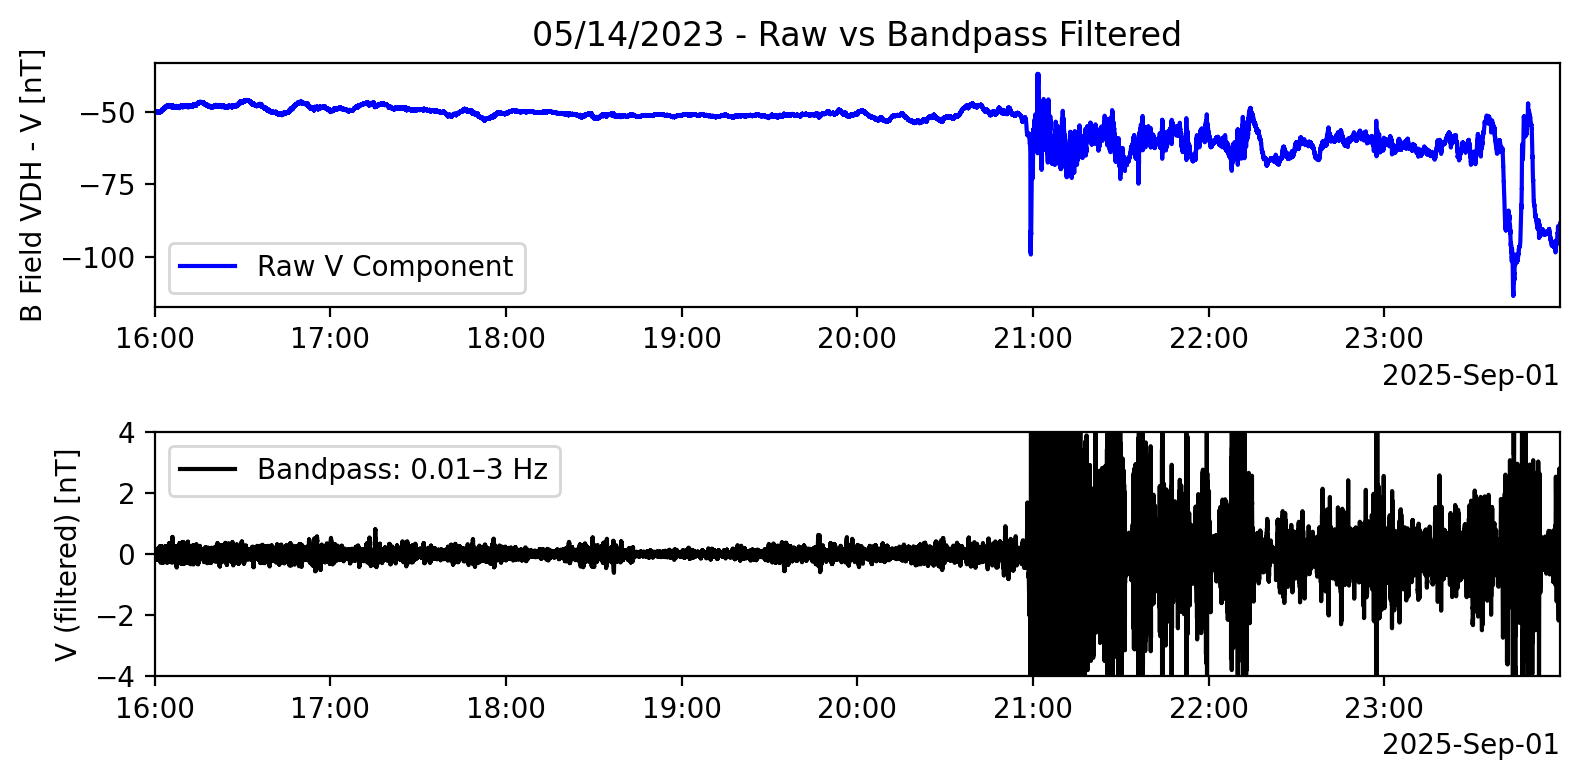

In [30]:
# Spectrogram of the bandpass-filtered signal# Spectrogram of the bandpass-filtered signal with display limited to ≥ 0.1 Hz
plt.figure(figsize=(50, 10), dpi=200)
plt.title('05/14/2023 - Spectrogram of Bandpass-Filtered V Component (≥ 0.1 Hz)')

cmap = plt.get_cmap('jet')
f, t, Sxx = signal.spectrogram(
    befilteredV,
    fs,
    noverlap=NFFT // 4,
    nperseg=NFFT,
    detrend='linear'
)

sg_db = 10 * np.log10(Sxx)
plt.pcolormesh(t, f, sg_db, cmap=cmap, vmin=db_min, vmax=db_max)
plt.colorbar(orientation='horizontal', label='Power [dB]')
plt.ylim([0, freqlim])  # Only show frequencies from 0.1 Hz and up
plt.xlim(0, 86399)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (seconds since start of day)")
formatter = matplotlib.ticker.FuncFormatter(timeTicks)
plt.gca().xaxis.set_major_formatter(formatter)
plt.show()
# Plot original and bandpass-filtered magnetic field data
f, axs = plt.subplots(2, 1, figsize=(8, 4), dpi=200)

axs[0].set_title('05/14/2023 - Raw vs Bandpass Filtered')
axs[0].plot(dts, VDH[:, 0], 'b-', label='Raw V Component')
axs[0].set_ylabel('B Field VDH - V [nT]')
axs[0].set_xlim(dts[576000], dts[-1])
format_time_axis(axs[0])
axs[0].legend()

axs[1].plot(dts, befilteredV, 'k-', label=f'Bandpass: {lowcut}–{highcut} Hz')
axs[1].set_ylabel("V (filtered) [nT]")
axs[1].set_ylim([-4, 4])
axs[1].set_xlim(dts[576000], dts[-1])
format_time_axis(axs[1])
axs[1].legend()

plt.tight_layout()
plt.show()




In [24]:
import copy
import pandas as pd

import matplotlib.colors as colors

#from ai import cdas
import soundfile as sf
from sonificationMethods.paulstretch_mono import paulstretch
#import json # for pretty output

#import pydsm

In [26]:
#apply paulstretch to a time series 
def thm_fgm_paulstretch(times,data,stretch=1,window=512./1024,samplerate=1024,return_time=False):
# Window for paulstretch is specifed so as to be equivalent to a window of 512 samples when using 
# the default sample rate of 44100
    paulStretch_data = paulstretch(data,stretch,window,samplerate=samplerate)
    
    if return_time == False:
        return paulStretch_data
    else:
        epochs = [ii.timestamp() for ii in times]
        epoch_stretch = np.linspace(epochs[0],epochs[-1],int(len(times) * stretch))
        epoch_stretch = epoch_stretch[:len(paulStretch_data)]
        times_interp_dt = np.array([datetime.datetime.fromtimestamp(ii) for ii in epoch_stretch])
        return times_interp_dt,paulStretch_data

In [28]:
#paulstretch
window=2048./44100 #~0.0116

#3-days, factor=6
stretch=1
#start_time_plot = datetime.datetime(2008, 11, 11,16)
#end_time_plot = datetime.datetime(2008, 11, 14,16)

samplerate = 44100
paulStretch_times, paulStretch_dB_phi_zero = thm_fgm_paulstretch(dts,VDH[:,0],samplerate=samplerate,
                                              stretch=stretch,window=window,return_time=True)

In [29]:
samplerate = 44100
#Normalises the data set by the maximum in the interval.
y2_real = paulStretch_dB_phi_zero / np.nanmax(np.abs(paulStretch_dB_phi_zero))
start_time = dts[0]
end_time = dts[-1]

sf.write('goesr_V_norm_'+
         start_time.strftime("%Y%m%d")+'_'+
         end_time.strftime("%Y%m%d")+'_paulstretch'+
         str(stretch)+'.wav', y2_real, samplerate)

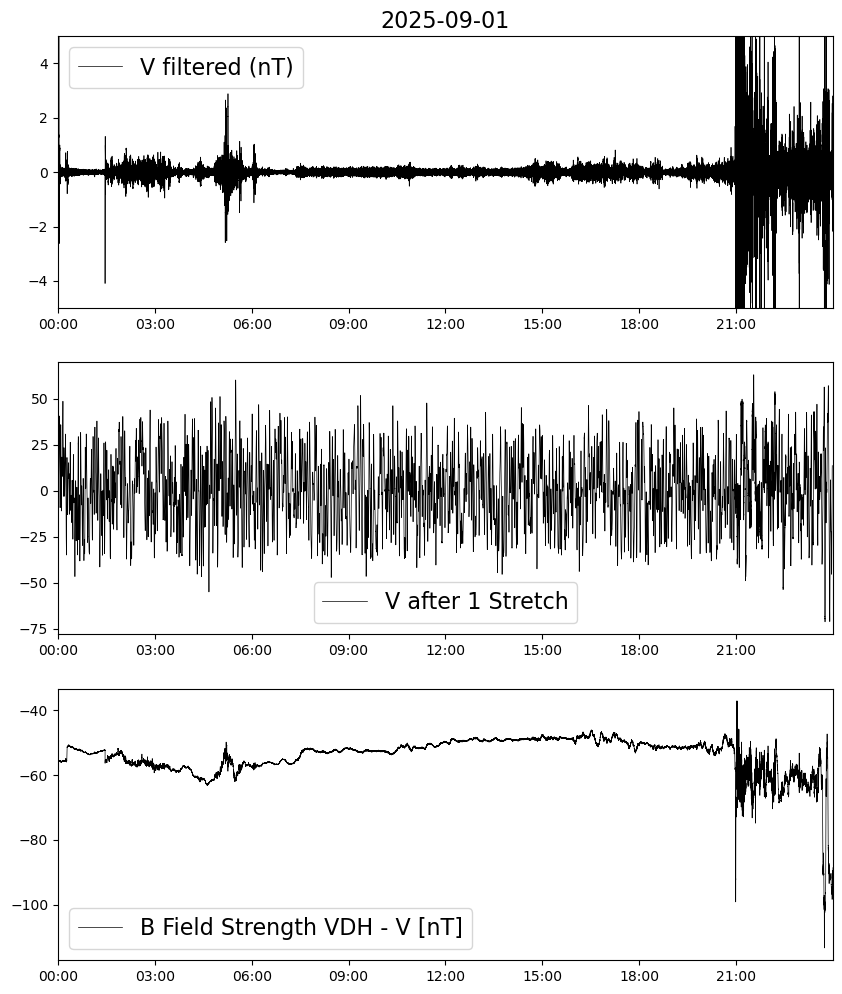

In [32]:
fig, (bx1,cx1,ax1) = plt.subplots(3,1,figsize=(10,12))
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16

start_time_plot = dts[0] #dts[576000]
end_time_plot = dts[-1]

xlim=[start_time_plot,end_time_plot]

fig.patch.set_facecolor('w')
ax1.plot(dts,VDH[:,0],'k', linewidth=0.5,label='B Field Strength VDH - V [nT]')
ax1.set(xlim=xlim)#,ylim=[-20,20]
ax1.legend(fontsize=16)

#bx1.plot(paulStretch_times,y2,'b', linewidth=0.5)
bx1.plot(dts, befilteredV,'k', linewidth=0.5,label='V filtered (nT)')
bx1.set(xlim=xlim,ylim=[-5,5])
bx1.legend(fontsize=16)

cx1.plot(paulStretch_times,paulStretch_dB_phi_zero,'k', linewidth=0.5,label='V after 1 Stretch')
cx1.set(xlim=xlim)#,ylim=[-20,20]
cx1.legend(fontsize=16)

if (end_time_plot-start_time_plot).days > 1:
    bx1.set_title(start_time_plot.strftime("%Y"),fontsize=16)
    myFmt = mdates.DateFormatter('%H:%M\n%m-%d')
else:
    bx1.set_title(start_time_plot.strftime("%Y-%m-%d"),fontsize=16)
    myFmt = mdates.DateFormatter('%H:%M')
    
ax1.xaxis.set_major_formatter(myFmt)
bx1.xaxis.set_major_formatter(myFmt)
cx1.xaxis.set_major_formatter(myFmt)

plt.show()

In [33]:
#sf.write('PSP_Bx_norm_'+
#         start_time.strftime("%Y%m%d")+'_'+
#         end_time.strftime("%Y%m%d")+'_paulstretch'+
#         str(stretch)+'_final.ogg', y2_real, samplerate)

In [34]:
#paulstretch
window=2048/44100 #~0.0116

#3-days, factor=6
stretch=1
#start_time_plot = datetime.datetime(2008, 11, 11,16)
#end_time_plot = datetime.datetime(2008, 11, 14,16)

samplerate = 44100
paulStretch_times, paulStretch_dB_phi_zero = thm_fgm_paulstretch(dts,befilteredV,samplerate=samplerate,
                                              stretch=stretch,window=window,return_time=True)

#samplerate = 44100
#Normalises the data set by the maximum in the interval.
y2_real = paulStretch_dB_phi_zero / np.nanmax(np.abs(paulStretch_dB_phi_zero))
start_time = dts[0]
end_time = dts[-1]

sf.write('goesr_V_befilteredV_norm_'+
         start_time.strftime("%Y%m%d")+'_'+
         end_time.strftime("%Y%m%d")+'_paulstretch'+
         str(stretch)+'.wav', y2_real, samplerate)